In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from avcv.all import *
from models import get_stn
from utils.download import download_model, PRETRAINED_TEST_HYPERPARAMS
from utils.vis_tools.helpers import load_pil, save_image

model_class = 'ir_face'  # choose the class you want to use
resolution = 256  # resolution the input image will be resized to (can be any power of 2)
# image_path = 'my_image.jpeg'  # path to image you want to align

import torch

In [94]:
def load_pil(path, resolution=None):
    arr = mmcv.imread(path, 0)
    arr = np.stack([arr]*3, -1)
    img = Image.fromarray(arr)
    if resolution is not None:
        img = img.resize((resolution, resolution), Image.LANCZOS)
    img = torch.tensor(np.asarray(img), device='cpu', dtype=torch.float).unsqueeze_(0).permute(0, 3, 1, 2)
    img = img.div(255.0).add(-0.5).mul(2)  # [-1, 1]
    return img  

In [95]:
from models import total_variation_loss
@torch.inference_mode()
def compute_flow_scores(batch, t):
    batch = batch.to('cuda')
    # batch, _, _ = determine_flips(args, t, None, batch)
    _, flows = t(batch, return_flow=True, iters=1, padding_mode='border')
    smoothness = total_variation_loss(flows, reduce_batch=False)
    return smoothness


In [96]:
def unnorm(img):
    img = (img-img.min())/(img.max()-img.min())
    img = img*255
    img = img.permute([1,2,0]).cpu().numpy().astype('uint8')
    return img
    # return img.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()

In [97]:
ckpt = download_model(model_class)  # download model weights
stn = get_stn(['similarity', 'flow'], flow_size=128, supersize=resolution, num_heads=1).to('cuda')  # instantiate STN
stn.load_state_dict(ckpt['t_ema'])  # load weights
test_kwargs = PRETRAINED_TEST_HYPERPARAMS[model_class]  # load test-time hyperparameters


In [98]:
class DS:
    def __init__(self, paths, out_paths):
        self.paths = paths
        self.out_paths = out_paths
    def __getitem__(self, idx):
        return load_pil(self.paths[idx], resolution)[0], self.out_paths[idx]
    def __len__(self):
        return len(self.paths)

In [38]:
import torch
meta_path = '/home/anhvth8/data/eyestate-datasset/rldd_vit_196k.csv'
df = pd.read_csv(meta_path, index_col=0)
def gen_congeal_path(path):
    assert 'croped_faces' in path
    return path.replace('/croped_faces/', '/croped_congeal_faces/')
df['exists'] = df.path.apply(osp.exists)
df = df[df['exists']]
df['congeal_path'] = df.path.apply(gen_congeal_path)

In [153]:
n = len(df)
ds = DS(df.path[:n].tolist(), df.congeal_path[:n].tolist())
dl = torch.utils.data.DataLoader(ds, 10, num_workers=10)

In [154]:
outs = []
scores = []
with torch.no_grad():
    pbar = tqdm(dl, total=len(dl))
    for input_img, out_path in pbar:
        aligned_img = stn.forward(input_img.cuda(), output_resolution=resolution, **test_kwargs)  # forward pass through the STN
        aligned_img = [unnorm(_) for _ in aligned_img]
        for ali, op in zip(aligned_img, out_path):
            mmcv.imwrite(ali, op)
            outs.append(op)
        scores.extend((-compute_flow_scores(input_img, stn)).cpu().numpy().tolist())
        

 25%|██████████████████████████████████▋                                                                                                       | 10930/43467 [18:10<53:31, 10.13it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe510af6ca0>
Traceback (most recent call last):
  File "/home/anhvth8/.conda/envs/gg/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/anhvth8/.conda/envs/gg/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1445, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/anhvth8/.conda/envs/gg/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/anhvth8/.conda/envs/gg/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/anhvth8/.conda/envs/gg/lib/python3.8/multiprocessing/connection.py", lin

KeyboardInterrupt: 

In [36]:
# out_df = pd.DataFrame(zip(outs, scores), columns=['path', 'flow_score'])

In [37]:
# out_df.to_csv(meta_path.replace('.csv', '_gangealing_out.csv'))

In [133]:
# norm_scores = (scores-scores.min())/(scores.max()-scores.min())

In [34]:
paths, scores = [], []
for i in range(8):
    ps, ss = mmcv.load(f'/tmp/out_{i}.pkl')
    paths.extend(ps)
    scores.extend(ss)

In [40]:
df = df.set_index('congeal_path')

In [42]:
# df

In [43]:
df.loc[paths, 'flow_score'] = scores

In [55]:
df.to_csv('/home/anhvth8/data/eyestate-datasset/rldd_vit_196k_congeal.csv')

In [89]:
frac = len(df)//100
s = frac*5
rows = df.sort_values('flow_score')[s:s+10]

In [90]:
imgs = []
for _, row in rows.iterrows():
    img = mmcv.imread(row.name)
    img1 = mmcv.imread(row.path)
    img1 = mmcv.imresize_like(img1, img)
    imgs.append(np.concatenate([img, img1], 1)[...,::-1])

2022-07-10 13:06:49.113 | INFO     | avcv.visualize:plot_images:29 - Grid size: (3, 3)


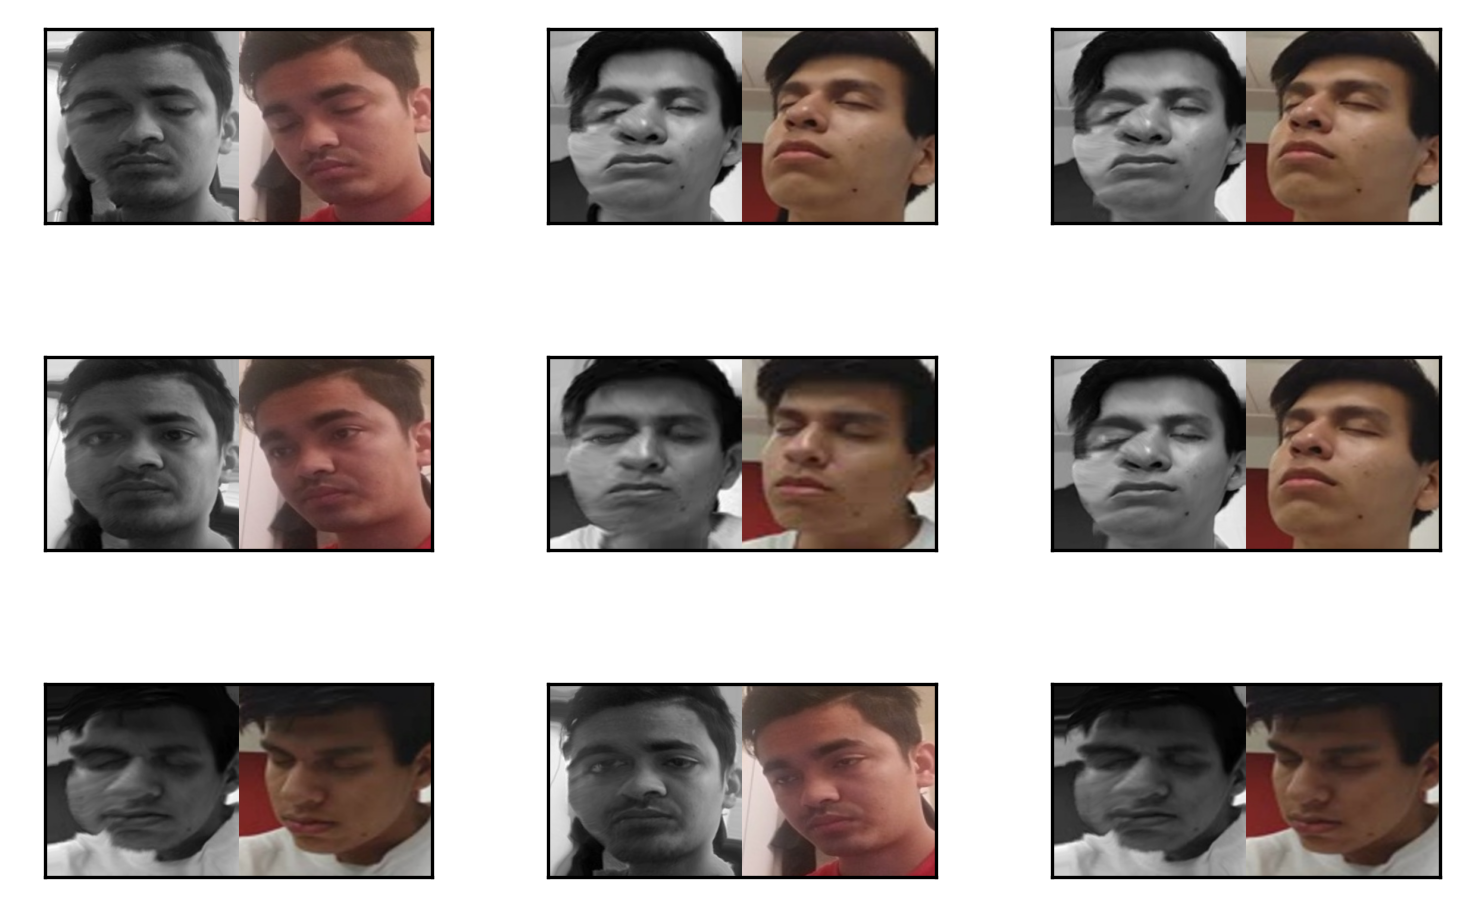

In [91]:
plot_images(imgs)